## Generando dígitos en PyTorch

## PyTorch

PyTorch es una de las bibliotecas de deep learning más utilizadas en el mundo. Desafortunadamente, a pesar de nuestros esfuerzos por simplificar el código lo más posible, algunas partes de esta sesión práctica pueden parecer un poco crípticas para aquellos que son nuevos en PyTorch. Idealmente, los principiantes deberían primero familiarizarse con PyTorch a través de uno o dos tutoriales como

* [Deep Learning Con PyTorch: Un Tutorial de 60 Minutos](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Entrenando un Clasificador en CIFAR10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

antes de programar autoencoders. Desafortunadamente, puede que no tengan suficiente tiempo para revisar estos tutoriales durante el tiempo limitado de la sesión práctica.

Por lo tanto, sugerimos que comiencen a experimentar con estos dos notebooks de autoencoders, ajusten algunos hiperparámetros, reentrenar las redes, y hagan preguntas si tienen alguna duda.

Posteriormente, si quieren saber más sobre los aspectos técnicos de PyTorch, tómense el tiempo para navegar por estos tutoriales de PyTorch. ¡Verán que PyTorch es una herramienta formidable!

### Comencemos por mirar nuestros datos
El conjunto de datos MNIST (Modified National Institute of Standards and Technology) es una base de datos de dígitos escritos a mano que se utiliza comúnmente para entrenar sistemas de procesamiento de imágenes. Este conjunto de datos contiene:

- 60,000 imágenes de entrenamiento
- 10,000 imágenes de prueba
- Cada imagen es de 28x28 píxeles en escala de grises
- Los valores de los píxeles van de 0 (negro) a 1 (blanco)
- Cada imagen está etiquetada con el dígito que representa (0-9)

Es considerado el "Hola Mundo" del aprendizaje profundo y es ideal para iniciarse en el reconocimiento de patrones y las redes neuronales.

Vamos a visualizarlos!

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.28MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 244kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.79MB/s]


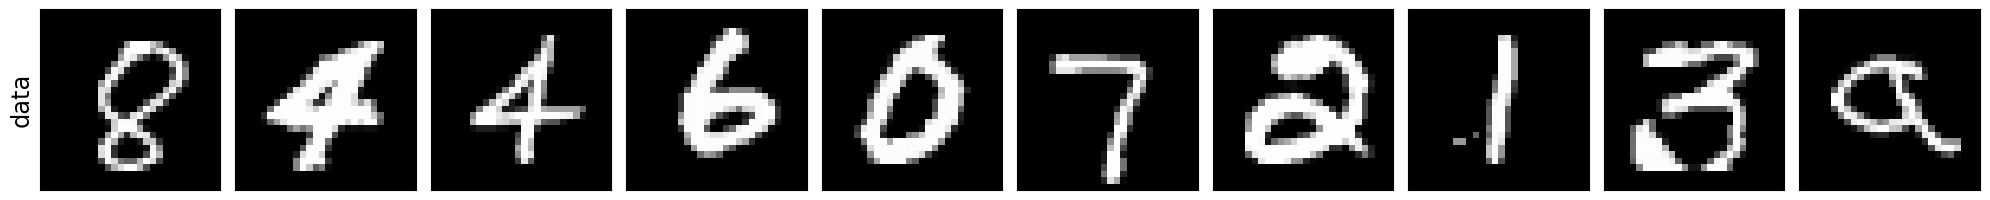

In [7]:
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

from src.visualization.utils import display_data_samples

# MNIST consists of 28x28 images, so the size of the data is
data_shape = 28, 28
data_size = data_shape[0] * data_shape[1]

# Download and prepare data
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST(root="data", download=True, train=True, transform=transform)
mnist_test = MNIST(root="data", download=True, train=False, transform=transform)

# Check data by displaying random images
samples_indices = np.random.randint(len(mnist_train), size=10)
mnist_img_list = [mnist_train[sample_idx][0] for sample_idx in samples_indices]
display_data_samples(data=mnist_img_list)

In [8]:
# What are `mnist_train` and `mnist_test`?  Let's look at it.
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Cargando nuestros datos

Image size =  (1, 28, 28)
Image size =  (28, 28)
The image label is  5


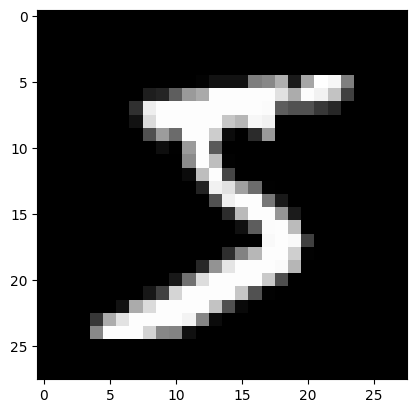

In [9]:
import matplotlib.pyplot as plt

# Get the first training image and its class label
sample_image = mnist_train[0][0]  # sample_image is a "PyTorch tensor"
sample_label = mnist_train[0][1]

# Convert the Tensor into a numpy array
sample_image_np = sample_image.numpy()
print("Image size = ", sample_image_np.shape)

# Call "squeeze" to remove the first dimension
sample_image_np = sample_image_np.squeeze(0)
print("Image size = ", sample_image_np.shape)

# Plot
plt.imshow(sample_image_np)
print("The image label is ", sample_label)

### Construyamos un autoencoder determinista profundo

Aquí construiremos un autoencoder simple con solo capas **densas** (también conocidas como completamente conectadas) y **ReLUs**. En PyTorch, una capa densa se denomina **Linear**.

Tanto el codificador como el decodificador tienen **3 capas** y el espacio latente tiene **32 dimensiones**.

Dado que los píxeles tienen valores entre 0 y 1, la última función de activación es una **Sigmoid**.

In [10]:
from torch import nn


# Let's define the encoder architecture we want,
# with some options to configure the input and output size
def make_encoder(data_size, latent_space_size):
    return nn.Sequential(
        nn.Linear(data_size, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, latent_space_size),
    )


# Same thing for the decoder
def make_decoder(data_size, latent_space_size):
    return nn.Sequential(
        nn.Linear(latent_space_size, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, data_size),
        nn.Sigmoid(),
    )


# Now let's build our networks, with an arbitrary dimensionality of the latent space
# and an input and output size depending on the data.
encoder = make_encoder(data_size, 32)
decoder = make_decoder(data_size, 32)

## Preguntas:
* ¿Qué vamos a generar?
* ¿Cuál es el tamaño del espacio latente del autoencoder?

In [11]:
import torch
import torch.nn.functional as F


def autoencoder_forward_pass(encoder, decoder, x):
    """AE forward pass.

    Args:
        encoder: neural net that predicts a latent vector
        decoder: neural net that projects a point in the latent space back into the image space
        x: batch of N MNIST images

    Returns:
        loss: crossentropy loss
        x_hat: batch of N reconstructed images
    """
    in_shape = x.shape  # Save the input shape
    encoder_input = torch.flatten(x, start_dim=1)  # Flatten the 2D image to a 1D tensor (for the linear layer)
    z = encoder(encoder_input)  # Forward pass on the encoder (to get the latent space vector)
    x_hat = decoder(z)  # Forward pass on the decoder (to get the reconstructed input)
    x_hat = x_hat.reshape(in_shape)  # Restore the output to the original shape
    loss = F.binary_cross_entropy(x_hat, x)  # Compute the reconstruction loss
    return loss, x_hat

## Entrenamiento del modelo

In [12]:
import os

from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define some training hyperparameters
epochs = 25
batch_size = 256


def train(forward_pass_fn, encoder, decoder, optimizer, train_data, val_data, device="cuda"):
    # Create dataloaders from the data
    # Those are PyTorch's abstraction to help iterate over the data
    data_loader_kwargs = {"batch_size": batch_size, "num_workers": os.cpu_count() - 1, "pin_memory": True}
    train_dataloader = DataLoader(train_data, shuffle=True, **data_loader_kwargs)
    val_dataloader = DataLoader(val_data, **data_loader_kwargs)

    # Ensure that the networks are on the requested device (typically a GPU)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    fit_pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    pbar_metrics = {"train_loss": None, "val_loss": None}
    for epoch in fit_pbar:
        # Train once over all the training data
        for x, _ in train_dataloader:
            x = x.to(device)  # Move the data tensor to the device
            optimizer.zero_grad()  # Make sure gradients are reset
            train_loss, _ = forward_pass_fn(encoder, decoder, x)  # Forward pass
            train_loss.backward()  # Backward pass
            optimizer.step()  # Update parameters w.r.t. optimizer and gradients
            pbar_metrics["train_loss"] = train_loss.item()
            fit_pbar.set_postfix(pbar_metrics)

        # At the end of the epoch, check performance against the validation data
        for x, _ in val_dataloader:
            x = x.to(device)  # Move the data tensor to the device
            val_loss, _ = forward_pass_fn(encoder, decoder, x)
            pbar_metrics["val_loss"] = val_loss.item()
            fit_pbar.set_postfix(pbar_metrics)

In [13]:
optimizer = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()])
train(autoencoder_forward_pass, encoder, decoder, optimizer, mnist_train, mnist_test)

Training:   0%|          | 0/25 [00:00<?, ?epoch/s]

Vamos a visualizar los resultados para el conjunto de test

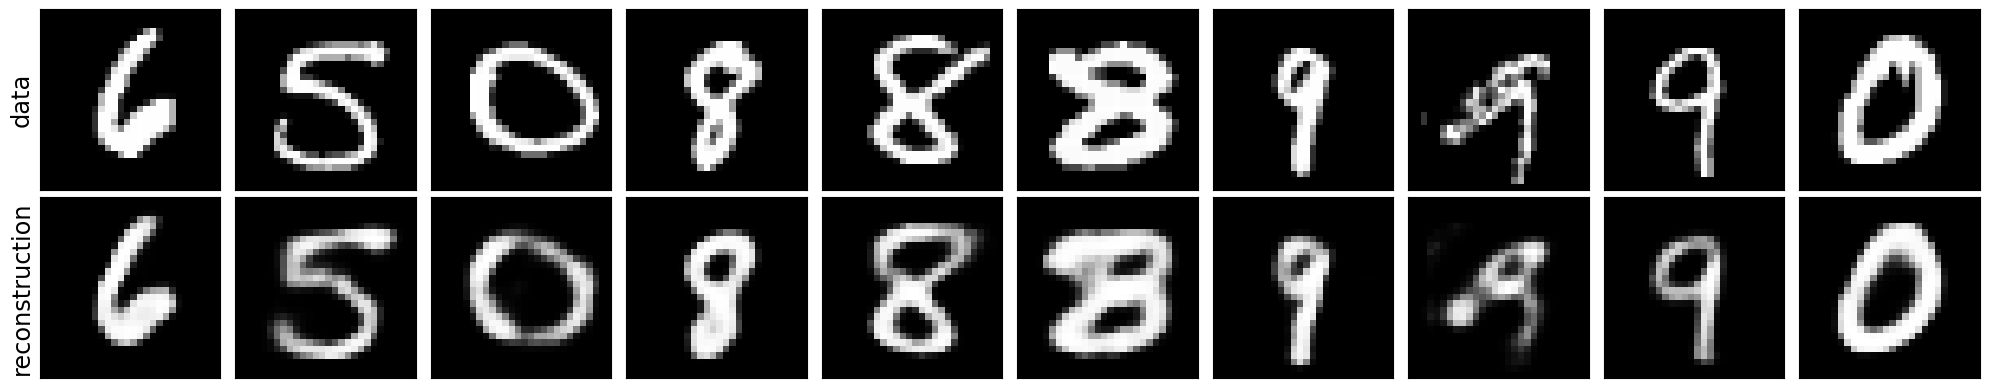

In [14]:
from src.visualization.utils import display_autoencoder_results

display_autoencoder_results(mnist_test, lambda x: autoencoder_forward_pass(encoder, decoder, x.cuda())[1])

### Espacio latente

Antes de pasar al autoencoder variacional, regresa al inicio de este notebook y reemplaza el tamaño del espacio latente de 32 a 2 dimensiones y vuelve a entrenar el autoencoder.

Una vez hecho esto, ejecuta la siguiente celda para visualizar el espacio latente.


In [37]:
# Run this cell only if the autoencoder has a latent space size of 2.

from src.visualization.latent_space import explore_latent_space

latent_space_size = 2

explore_latent_space(
    mnist_test,
    lambda x: encoder(torch.flatten(x, start_dim=1)),
    lambda z: decoder(z).reshape(data_shape),
    encodings_label="target",
)

Encoding the dataset items in the latent space...
Learning UMAP embedding for latent space vectors...


/home/emi/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


BokehModel(combine_events=True, render_bundle={'docs_json': {'a589124a-35e1-49ec-8026-34c69a27cb9d': {'version…

## Pregunta:

¿Por qué crees que con un espacio latente de 2 dimensiones obtenemos imágenes reconstruidas menos precisas (más borrosas)?

### Convirtamos nuestro autoencoder en variacional

Los autoencoders variacionales (VAE) son muy similares a los autoencoders. Las diferencias son tres:

* El codificador del VAE genera vectores de media y varianza  
* La entrada del decodificador es un vector muestreado aleatoriamente de una distribución Normal determinada por los vectores de media y varianza predichos
* La función de pérdida tiene 2 términos: la pérdida de reconstrucción (como en el AE normal) + la divergencia KL (para la salida del codificador)

Como el gradiente no puede retropropagarse a través de un método de muestreo aleatorio, los VAE siempre vienen con un **truco de reparametrización**.

In [ ]:
# Esta vez, empezamos directamente con un espacio latente de 2 dimensiones para visualizarlo fácilmente después
latent_space_size = 2

# En la práctica, un pequeño truco para implementar fácilmente las dos salidas del 
# codificador es simplemente duplicar el tamaño de su salida. Luego, podemos dividir 
# la salida por la mitad durante el paso hacia adelante!
vae_encoder = make_encoder(data_size, latent_space_size * 2)
vae_decoder = make_decoder(data_size, latent_space_size)

## Preguntas:

* En la celda anterior, usamos la misma función para construir las redes del codificador y decodificador del VAE que para el AE. La única diferencia es que el tamaño de salida del codificador está multiplicado por 2. ¿Por qué crees que es así?
* En la siguiente celda, incluimos el **truco de reparametrización** en el **paso hacia adelante**. ¿Recuerdas por qué esto tiene que hacerse?
* ¿Cuál es el tamaño del espacio latente del VAE?

### Necesitamos cambiar el algoritmo de entrenamiento para implementar el "truco de reparametrización"

In [18]:
def kl_div(mu, logvar):
    kl_div_by_samples = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kl_div_by_samples)


def vae_forward_pass(encoder, decoder, x):
    """VAE forward pass.

    Args:
        encoder: neural net that predicts a mean and a logvar vector
        decoder: neural net that projects a point in the latent space back into the image space
        x: batch of N MNIST images

    Returns:
        loss: crossentropy + kl_divergence loss
        x_hat: batch of N reconstructed images
    """
    in_shape = x.shape  # Save the input shape
    encoder_input = torch.flatten(x, start_dim=1)  # Flatten the 2D image to a 1D tensor (for the linear layer)
    encoding_distr = encoder(encoder_input)  # Forward pass on the encoder (to get the latent space posterior)
    # Nothing changed so far!

    # Second part of our trick!
    # We separate the (unique) latent space posterior into its two halves: mean and logvar
    mu, logvar = encoding_distr[:, :latent_space_size], encoding_distr[:, latent_space_size:]

    # Reparametrization trick
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Decoding mostly stays the same. The only difference is the added 4th line below
    x_hat = decoder(z)  # Forward pass on the decoder (to get the reconstructed input)
    x_hat = x_hat.reshape(in_shape)  # Restore the output to the original shape
    loss = F.binary_cross_entropy(x_hat, x)  # Compute the reconstruction loss
    loss += 5e-3 * kl_div(mu, logvar)  # Loss now also includes the KL divergence term
    return loss, x_hat

Now it's time to train our variational autoencoder!

In [19]:
optimizer = torch.optim.Adam([*vae_encoder.parameters(), *vae_decoder.parameters()])
train(vae_forward_pass, vae_encoder, vae_decoder, optimizer, mnist_train, mnist_test)

Training:   0%|          | 0/25 [00:00<?, ?epoch/s]

Now, let's take a look at the results on the test set.

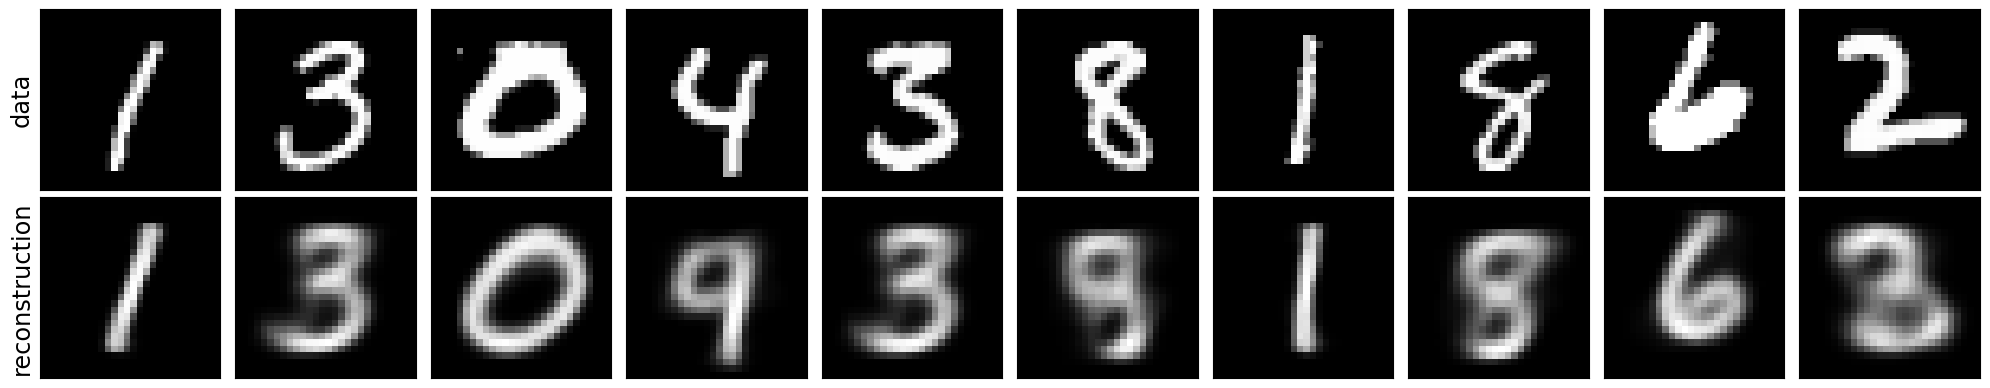

In [20]:
display_autoencoder_results(mnist_test, lambda x: vae_forward_pass(vae_encoder, vae_decoder, x.cuda())[1])

## More visualization 

Now that we have a latent space in two dimensions, we can easily visualize it and look at how the data is
distributed.

### See the difference between this latent space and that of the previous autoencoder?

In [21]:
from src.visualization.latent_space import explore_latent_space

explore_latent_space(
    mnist_test,
    lambda x: vae_encoder(torch.flatten(x, start_dim=1))[:, :latent_space_size],
    lambda z: vae_decoder(z).reshape(data_shape),
    encodings_label="target",
)

Encoding the dataset items in the latent space...


BokehModel(combine_events=True, render_bundle={'docs_json': {'e58c12d7-f01a-4fe0-8b00-5403454623e6': {'version…

### In the next cell, we shall decode one selected vector `z` in the latent space.  Change the content of that vector and you will see what happens!

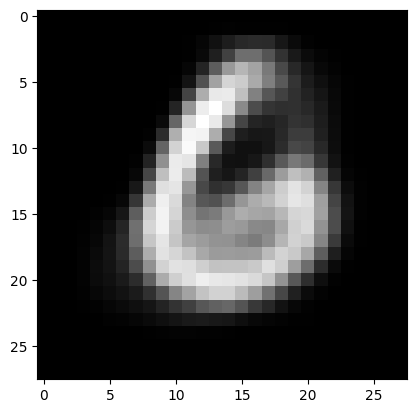

In [36]:
import matplotlib.pyplot as plt

z = [-1, -1]  # 2D latent vector

z_torch = torch.tensor(z, dtype=torch.float).cuda()  # convert Z into a PyTorch tensor

sample = vae_decoder(z_torch).reshape(data_shape)  # decode the latent vector with the VAE decoder

plt.imshow(sample.detach().cpu().numpy())  # plot the resulting image